# Running Task 2 with Pretrained Weights
### Cloning Required Repositories, Installing Libraries and Dependencies, and Importing Packages


In [1]:
# Download and install Pytorch for CUDA 10.2
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu102
# Download and install Pytorch for CUDA 11.3
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113
    
!pip install intern[cloudvolume]
!pip install scikit-learn
!pip install timm
!pip install pretrainedmodels
!pip install efficientnet_pytorch

# Setting up the segmentation_models.pytorch library
!pip install github-clone
!ghclone https://github.com/qubvel/segmentation_models.pytorch/tree/master/segmentation_models_pytorch 
!cp -rf segmentation_models_pytorch ../MTNeuro/.
!rm -rf segmentation_models_pytorch


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu102


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


Cloning into 'segmentation_models_pytorch'...
done.


'cp' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
#import libraries and set random seed
import sys
import matplotlib.pyplot as plt
import numpy as np
import json as json
from tqdm import tqdm

#pytorch imports
import torch
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from intern import array

#sci-kit learn imports
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sys.path.append('../MTNeuro/')            #setting the location to look for the required packages
#BossDB library and MTNeuro dataset loader
from bossdbdataset import BossDBDataset               

from trainer import Trainer                    #trainer function used to train the models
from models.unet import UNet                   #UNet model. From: https://github.com/johschmidt42/PyTorch-2D-3D-UNet-Tutorial
import segmentation_models_pytorch as smp      #SMP library (used for calculation of performance metrics: https://github.com/qubvel/segmentation_models.pytorch

torch.manual_seed(0)
np.random.seed(0)

### Specifying the Model, Setting, and Mode for Image Segmentation

2D Models | 3D Models | Settings | Modes
----------|-----------|----------|--------
Unet | UNet | 3class | 2D
smp_UnetPlusPlus | mzp_HighResNet | 4 class | 3D
smp_PSPNet | mzp_VNetLight |
smp_PAN |
smp_FPN |
smp_MAnet |

3class Setting: Segmentation of cell bodies, blood vessels, and axons/background

4class Setting: Segmentation of cell bodies, blood vessels, axons, and background

In [2]:
Model = 'UNet'         #Eg:- UNet, smp_PAN
Setting = '3class'     #Eg:- 3class, 4class
Mode = '2D'            #Eg:- 3D, 2D

fh = open('config.txt', 'w')
fh.write(Model+' '+Setting+' '+Mode)
fh.close()

### Loading the Appropriate Configuration File


In [4]:
##load the task config for specified mode and setting that specifies the x,y ranges to pick from the data for forming the slices
task_config = json.load(open('../MTNeuro/taskconfig/task2_'+str(Mode)+'_'+str(Setting)+'.json'))

##Load the network config for the specified mode and setting, with the batch size and model config information
network_config = json.load(open('../MTNeuro/networkconfig/'+str(Model)+'_'+str(Mode)+'_'+str(Setting)+'.json'))

### Loading the Model and Pretrained Weights

#### Loading the Model

In [5]:
# Specify device
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

# Specify model
if network_config["model"] == "UNet":
  print('loading UNet model')
  model = UNet(in_channels=network_config['in_channels'],
                out_channels=network_config['classes'],
                n_blocks=network_config['n_blocks'],
                start_filters=network_config['start_filters'],
                activation=network_config['activation'],
                normalization=network_config['normalization'],
                conv_mode=network_config['conv_mode'],
                dim=network_config['dim']).to(device)

if network_config["model"] == "smp_UnetPlusPlus":
  print('loading UnetPlusPlus model')
  model = smp.UnetPlusPlus(
            encoder_name=network_config["encoder_name"],        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=network_config["encoder_weights"],     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=network_config["in_channels"],                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=network_config["classes"],                      # model output channels (number of classes in your dataset)
        ).to(device)

if network_config["model"] == "smp_MAnet":
  print('loading MAnet model')
  model = smp.MAnet(
            encoder_name=network_config["encoder_name"],        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=network_config["encoder_weights"],     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=network_config["in_channels"],                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=network_config["classes"],                      # model output channels (number of classes in your dataset)
        ).to(device)

if network_config["model"] == "smp_PAN":
  print('loading PAN model')
  model = smp.PAN(
            encoder_name=network_config["encoder_name"],        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=network_config["encoder_weights"],     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=network_config["in_channels"],                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=network_config["classes"],                      # model output channels (number of classes in your dataset)
        ).to(device)

if network_config["model"] == "smp_Linknet":
  print('loading Linknet model')
  model = smp.Linknet(
            encoder_name=network_config["encoder_name"],        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=network_config["encoder_weights"],     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=network_config["in_channels"],                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=network_config["classes"],                      # model output channels (number of classes in your dataset)
        ).to(device)

if network_config["model"] == "smp_FPN":
  print('loading FPN model')
  model = smp.FPN(
            encoder_name=network_config["encoder_name"],        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=network_config["encoder_weights"],     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=network_config["in_channels"],                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=network_config["classes"],                      # model output channels (number of classes in your dataset)
        ).to(device)

if network_config["model"] == "smp_PSPNet":
  print('loading PSPNet model')
  model = smp.PSPNet(
            encoder_name=network_config["encoder_name"],        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=network_config["encoder_weights"],     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=network_config["in_channels"],                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=network_config["classes"],                      # model output channels (number of classes in your dataset)
        ).to(device)

if network_config["model"] == "smp_DeepLabV3Plus":
  print('loading DeepLabV3Plus model')
  model = smp.DeepLabV3Plus(
            encoder_name=network_config["encoder_name"],        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=network_config["encoder_weights"],     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=network_config["in_channels"],                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=network_config["classes"],                      # model output channels (number of classes in your dataset)
        ).to(device)


loading UNet model


#### Downloading the Pretrained Weights

In [6]:
%%bash
IFS=' ' read -r model setting mode <<< `cat config.txt`
#echo $model
#eho $setting
#echo $mode
if [ "$mode" == "2D" ]; then
  if [ "$setting" == "3class" ]; then
    if [ "$model" == "UNet" ]; then
      echo "Hi!"
      echo "Loading $model $mode $setting" && wget https://www.dropbox.com/s/7zwh7j43ozui7t1/UNet_2D_3class.pt -q --show-progress --progress=dot
    elif [ "$model" == "smp_UnetPlusPlus" ]; then
      echo "Loading $model $mode $setting" && wget https://www.dropbox.com/s/r0v3vvwlqelpbac/smp_UnetPlusPlus_3class.pt -q --show-progress --progress=dot
    elif [ "$model" == "smp_PSPNet" ]; then
      echo "Loading $model $mode $setting" && wget https://www.dropbox.com/s/h4qmkbj7y878ivt/smp_PSPNet_3class.pt -q --show-progress --progress=dot
    elif [ "$model" == "smp_PAN" ]; then
      echo "Loading $model $mode $setting" && wget https://www.dropbox.com/s/xph537dtsq1qxja/smp_PAN_3class.pt -q --show-progress --progress=dot
    elif [ "$model" == "smp_FPN" ]; then
      echo "Loading $model $mode $setting" && wget https://www.dropbox.com/s/iu8ute75j4tbpxf/smp_FPN_3class.pt -q --show-progress --progress=dot
    elif [ "$model" == "smp_MAnet" ]; then
      echo "Loading $model $mode $setting" && wget https://www.dropbox.com/s/d9kll74duwo2cbr/smp_MAnet_3class.pt -q --show-progress --progress=dot
    fi
  elif [ "$setting" == "4class" ]; then
    if [ "$model" == "UNet" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/xd0hgpq36hjjt21/UNet_2D_noZI.pt -q --show-progress --progress=dot
    elif [ "$model" == "smp_UnetPlusPlus" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/7rbhu074454h6we/smp_UnetPlusPlus_noZI.pt -q --show-progress --progress=dot
    elif [ "$model" == "smp_PSPNet" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/u043cojfd12xkoc/smp_PSPNet_noZI.pt -q --show-progress --progress=dot
    elif [ "$model" == "smp_PAN" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/w5fi601apllhzka/smp_PAN_noZI.pt -q --show-progress --progress=dot
    elif [ "$model" == "smp_FPN" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/k14btyrs4lif0z0/smp_FPN_noZI.pt -q --show-progress --progress=dot
    elif [ "$model" == "smp_MAnet" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/3qyxozy02app7e6/smp_MAnet_noZI.pt -q --show-progress --progress=dot
    fi
  fi
elif [ "$mode" == "3D" ]; then
  if [ "$setting" == "3class" ]; then
    if [ "$model" == "mzp_HighResNet" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/ffblz0irsjemvpw/mzp_HighResNet_3D_3class.pt -q --show-progress --progress=dot
    elif [ "$model" == "mzp_VNetLight" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/otrga1kr9lishim/mzp_VNetLight_3D_3class.pt -q --show-progress --progress=dot
    elif [ "$model" == "UNet" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/f5db56f41pcmyxo/UNet_3D_3class.pt -q --show-progress --progress=dot
    fi
  elif [ "$setting" == "4class" ]; then
    if [ "$model" == "mzp_HighResNet" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/255medlec507t33/mzp_HighResNet_3D_noZI.pt -q --show-progress --progress=dot
    elif [ "$model" == "mzp_VNetLight" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/1xbmjcvjpi5fix5/mzp_VNetLight_3D_noZI.pt -q --show-progress --progress=dot
    elif [ "$model" == "UNet" ]; then
      echo "Loading $model $model $mode $setting"
      wget https://www.dropbox.com/s/grlqwue5s2sttyb/UNet_3D_noZI.pt -q --show-progress --progress=dot
    fi
  fi
fi

Hi!
Loading UNet 2D 3class



     0K .......... .......... .......... .......... ..........  0% 3.84M 2s
    50K .......... .......... .......... .......... ..........  1% 13.2M 1s
   100K .......... .......... .......... .......... ..........  1% 7.31M 1s
   150K .......... .......... .......... .......... ..........  2% 5.87M 1s
   200K .......... .......... .......... .......... ..........  3% 4.37M 1s
   250K .......... .......... .......... .......... ..........  3% 11.5M 1s
   300K .......... .......... .......... .......... ..........  4% 3.66M 1s
   350K .......... .......... .......... .......... ..........  5%  157M 1s
   400K .......... .......... .......... .......... ..........  5% 6.91M 1s
   450K .......... .......... .......... .......... ..........  6% 3.47M 1s
   500K .......... .......... .......... .......... ..........  7% 9.69M 1s
   550K .......... .......... .......... .......... ..........  7% 12.7M 1s
   600K .......... .......... .......... .......... ..........  8% 9.39M 1s
   650K ...

  5400K .......... .......... .......... .......... .......... 70% 8.66M 0s
  5450K .......... .......... .......... .......... .......... 70% 6.41M 0s
  5500K .......... .......... .......... .......... .......... 71%  127M 0s
  5550K .......... .......... .......... .......... .......... 72% 6.18M 0s
  5600K .......... .......... .......... .......... .......... 72% 2.59M 0s
  5650K .......... .......... .......... .......... .......... 73%  160M 0s
  5700K .......... .......... .......... .......... .......... 74%  174M 0s
  5750K .......... .......... .......... .......... .......... 74%  173M 0s
  5800K .......... .......... .......... .......... .......... 75% 9.55M 0s
  5850K .......... .......... .......... .......... .......... 76% 5.89M 0s
  5900K .......... .......... .......... .......... .......... 76%  215M 0s
  5950K .......... .......... .......... .......... .......... 77% 6.44M 0s
  6000K .......... .......... .......... .......... .......... 78% 3.76M 0s
  6050K ....

#### Loading the Pretrained Weights

In [7]:
#load saved weights here. Example path (after download): Models/Task2/2D/UNet_2D/3_Class_Setting/smp_UNet_2D_3class_seed1/UNet_2D_3class.pt
#checkpoint = torch.load('Models/Task2/'+str(Mode)+'/'+str(Model)+'/'+str(Setting)+'_Setting/'+str(Model)+'_'+str(Setting)+'_seed1/'+str(Model)+'_'+str(Setting)+'.pt')
if Setting=='3class':
  checkpoint = torch.load(str(Model)+'_'+str(Mode)+'_'+str(Setting)+'.pt', map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint)
else:
  checkpoint = torch.load(str(Model)+'_'+str(Mode)+'_noZI.pt', map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint)

### Loading and Preparing the DataLoader from BossDB

In [8]:
##Set-up the train dataloader and validation dataloader
transform = transforms.Compose([transforms.ToTensor(),])
test_data = BossDBDataset(task_config, None, 'val', image_transform=transform, mask_transform=transform)

test_dataloader = torch.utils.data.DataLoader(dataset=test_data,
                                        batch_size=network_config['batch_size'],
                                        shuffle=False)

### Model Prediction

#### Prediction Function


In [9]:
#function to predict using trained model
def predict(img, model, device):
        model.eval()
        x = img.to(device)  # to torch, send to device
        with torch.no_grad():
            out = model(x)  # send through model/network

        out_argmax = torch.argmax(out, dim=1)  # perform softmax on outputs
        return out_argmax

#### Prediction Loop


In [10]:
#batch_iter = tqdm(enumerate(test_dataloader), 'test', total=len(test_dataloader), leave=False)
batch_iter = enumerate(test_dataloader)

# predict the segmentations of test set
tp_tot = torch.empty(0,network_config['classes'])
fp_tot = torch.empty(0,network_config['classes'])
fn_tot = torch.empty(0,network_config['classes'])
tn_tot = torch.empty(0,network_config['classes'])

y_ = []
x_ = []
output_ = []
for i, (x, y) in batch_iter:
    # x = torch.permute(x, (0, 1, 3, 2))#.float() / 255 # Permute (batch x H x W x C) --> (batch x C x H x W) and cast to float
    target = y.to(device) #can do this on CPU
    y_.append(y)
    x_.append(x.squeeze())
    with torch.no_grad():
        # get the output image (make prediction)
        output = predict(x, model, device)
        output_.append(output)
        tp_, fp_, fn_, tn_ = smp.metrics.get_stats(output, target, mode='multiclass', num_classes = network_config['classes'])
        tp_tot = torch.vstack((tp_tot,tp_))
        fp_tot = torch.vstack((fp_tot,fp_))
        fn_tot = torch.vstack((fn_tot,fn_))
        tn_tot = torch.vstack((tn_tot,tn_))

#### Visualizing Model Predictions

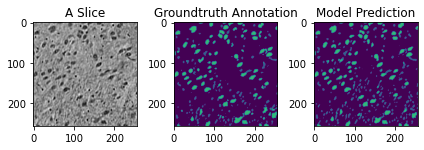

In [11]:
plt.subplot(1,3,1)
plt.imshow(x.squeeze().cpu()[0], cmap='gray')
plt.title("A Slice")
plt.subplot(1,3,2)
plt.imshow(y.squeeze().cpu()[0], vmin=0, vmax=3)
plt.title("Groundtruth Annotation")
plt.subplot(1,3,3)
plt.imshow(output.squeeze().cpu()[0], vmin=0, vmax=3)
plt.title("Model Prediction")
plt.tight_layout()

#### Calculating Performance Metrics

In [12]:
# Accuracy: (tp + fp) / (fp + tn + fn + tp)
acc = (tp_tot.mean(dim=0)+tn_tot.mean(dim=0))/(fp_tot.mean(dim=0)+tn_tot.mean(dim=0)+fn_tot.mean(dim=0)+tp_tot.mean(dim=0)) 
print('new Accuracy per Class:')
print(np.array(acc.cpu()))

# Balanced Accuracy:  (Specificity + Sensitivity / 2)
spec =  (tn_tot[:,1:].mean())/(fp_tot[:,1:].mean()+tn_tot[:,1:].mean())
sens =  (tp_tot[:,1:].mean())/(fn_tot[:,1:].mean()+tp_tot[:,1:].mean())
balacc = (spec + sens)/2
print(f'new Balanced accuracy (No background): {balacc}')

# F1-score: 2* precision * recall / (precision + recall)
prec = tp_tot.mean(dim=0)/(fp_tot.mean(dim=0)+tp_tot.mean(dim=0))
reca = tp_tot.mean(dim=0)/(fn_tot.mean(dim=0)+tp_tot.mean(dim=0))
f1 = (2*reca*prec)/(reca+prec)
print(f'new F1-score: {np.array(f1.cpu())} Avg. F1-score: {f1.mean()}')

# IoU: tp /(fp + fn + tp)
iou = (tp_tot.mean(0))/(fp_tot.mean(0)+fn_tot.mean(0)+tp_tot.mean(0))
print(f'new IoU: {np.array(iou.cpu())} Avg. IoU-score: {iou.mean()}')

new Accuracy per Class:
[0.98390764 0.9836368  0.9843486 ]
new Balanced accuracy (No background): 0.9266831278800964
new F1-score: [0.9910187 0.7691103 0.8860567] Avg. F1-score: 0.8820618987083435
new IoU: [0.98219734 0.6248409  0.7954234 ] Avg. IoU-score: 0.800820529460907
